## Data Aquisition, Standardization & Feature Selection

First i load four rounds of Afrobarometer data (Round 7 through Round 10).
Because the survey question IDs change every few years, I’ve created dictionaries to rename them into a consistent set of variables.

Also apllying a specific mapping to Round 10, converting the French text responses for education, poverty, and internet usage into the standard numeric scales used in previous rounds. I am then merging all rounds into one "Master" dataset and cleaning out invalid survey codes (like 98 or 99) to ensure the data is ready for analysis.

 To optimize **computational efficiency and reduce data noise**, I performed feature subsetting using the dictionary keys. This ensured that only the variables pertinent to my desired analysis were retained in memory."

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Defining the mapping logic for all rounds
r7_c = {'REGION':'reg','Q1':'age','THISINT':'gen','URBRUR':'urb','Q97':'edu','Q91B':'net','Q8A':'p1','Q8B':'p2','Q8C':'p3','Q8D':'p4','Q8E':'p5'}
r8_c = {'REGION':'reg','Q1':'age','Q101':'gen','URBRUR':'urb','Q97':'edu','Q92I':'net','Q7A':'p1','Q7B':'p2','Q7C':'p3','Q7D':'p4','Q7E':'p5'}
r9_c = {'REGION':'reg','Q1':'age','Q100':'gen','URBRUR':'urb','Q94':'edu','Q90I':'net','Q6A':'p1','Q6B':'p2','Q6C':'p3','Q6D':'p4','Q6E':'p5'}
r10_c = {'REGION':'reg','Q1':'age','Q101':'gen','URBRUR':'urb','Q96':'edu','Q90J':'net', 'Q7A':'p1','Q7B':'p2','Q7C':'p3','Q7D':'p4','Q7E':'p5'}

# 2. Loading the files (Assuming they are in your current directory)
d7 = pd.read_csv("round_7.csv")[list(r7_c.keys())].rename(columns=r7_c).assign(s_year=2018)
d8 = pd.read_csv("round_8.csv")[list(r8_c.keys())].rename(columns=r8_c).assign(s_year=2021)
d9 = pd.read_csv("round_9.csv")[list(r9_c.keys())].rename(columns=r9_c).assign(s_year=2022)
d10 = pd.read_csv("round_10.csv")[list(r10_c.keys())].rename(columns=r10_c).assign(s_year=2024)

### Data Wrangling and Preprocessing

In [45]:
# 3. Specific Numeric Mapping for Round 10 (Standardizing strings to numbers)
edu_map = {'Pas d’enseignement formel': 0, 'Enseignement informel seulement': 1, 'Enseignement primaire inachevé': 2, 'Enseignement primaire achevé': 3, 'Enseignement secondaire / lycée inachevé': 4, 'Enseignement secondaire / lycée achevé': 5, 'Qualifications post-secondaires': 6, 'Université inachevée': 7, 'Université achevée': 8, 'Post-universitaire': 9}
pov_map = {'Jamais': 0, 'Juste 1 ou 2 fois': 1, 'Plusieurs fois': 2, 'Quelques fois': 3, 'Toujours': 4}
net_map = {'Jamais': 0, 'Moins d’une fois par mois': 1, 'Quelques fois par mois': 2, 'Quelques fois par semaine': 3, 'Tous les jours': 4}

d10['edu'] = d10['edu'].map(edu_map)
d10['net'] = d10['net'].map(net_map)
d10['gen'] = d10['gen'].map({'Homme': 1, 'Femme': 2})
d10['urb'] = d10['urb'].map({'Urbain': 1, 'Rural': 2})
for p in ['p1','p2','p3','p4','p5']: d10[p] = d10[p].map(pov_map)

# 4. Concatenating and final cleaning
master_df = pd.concat([d7, d8, d9, d10], ignore_index=True)

# Force everything to numeric to ensure R7, R8, and R9 are also numbers
for col in ['age', 'edu', 'net', 'p1', 'p2', 'p3', 'p4', 'p5', 'gen', 'urb']:
    master_df[col] = pd.to_numeric(master_df[col], errors='coerce')

# Filter out invalid entries (99,998, etc) and drop NaN
master_df = master_df[(master_df['age'] < 100) & (master_df['edu'] <= 9)].dropna()

print(f" Master dataset contains {len(master_df)} valid respondents.")


 Master dataset contains 4713 valid respondents.


## Feature Engineering and Contextualization
I am transforming the raw data into meaningful indicators.

**Birth Year** -> creates the historical timeline not affected by the year they were interview 

**Birth year Square** -> Polynomial factor to allow the model capture curves

**Poverty Score** -> From 5 lived-poverty indicators 

**isHighly_educated** -> Binary score for individuals that have any post high school education

**Anglophone vs Francophone** -> Seperate the datasets 

In [46]:
# 1. Calculating a consistent  timeline and social scores
master_df['birth_year'] = master_df['s_year'] - master_df['age']
master_df['poverty_score'] = master_df[['p1','p2','p3','p4','p5']].mean(axis=1)
master_df['is_highly_educated'] = (master_df['edu'] >= 6).astype(int)
master_df['is_female'] = (master_df['gen'] == 2).astype(int)
master_df['is_rural'] = (master_df['urb'] == 2).astype(int)

# 2. Defining the Regional Context (Anglophone NW/SW vs Francophone)
# These codes correspond to the North West and South West regions across different survey rounds
anglo_codes = ['North West', 'South West', 'NORD-OUEST', 'SUD-OUEST', 1228, 1231, 1229, 1232]
master_df['is_anglophone'] = master_df['reg'].apply(lambda x: 1 if x in anglo_codes else 0)

# 3. Engineering terms for non-linear modeling (Polynomials)
# Centering birth year helps stabilize the model and makes the intercept meaningful
master_df['birth_year_c'] = master_df['birth_year'] - master_df['birth_year'].mean()
master_df['birth_year_sq'] = master_df['birth_year_c'] ** 2
master_df['interaction'] = master_df['is_female'] * master_df['birth_year_c']

# 4. Splitting the data for comparison
df_nwsw = master_df[master_df['is_anglophone'] == 1].copy()
df_franco = master_df[master_df['is_anglophone'] == 0].copy()

print(f"NW/SW Sub-sample size: {len(df_nwsw)}")

NW/SW Sub-sample size: 1122


## Exploratory Data Analysis (The "Boy Child" Crises Baseline)

Before building my  model, I am performing an exploratory analysis to visualize the raw educational reality on the ground in the NW/SW. I am specifically comparing young men from the Crisis Generation (those born between 1998 and 2008 who were school-aged when the conflict began) against the older generations.

By grouping education into three main categories—Primary, Secondary, and Higher Education—I can see if there is a "Blocked Pipeline." My goal here is to determine if young men are still finishing high school but failing to transition into Universities or professional programs compared to their fathers' generation.

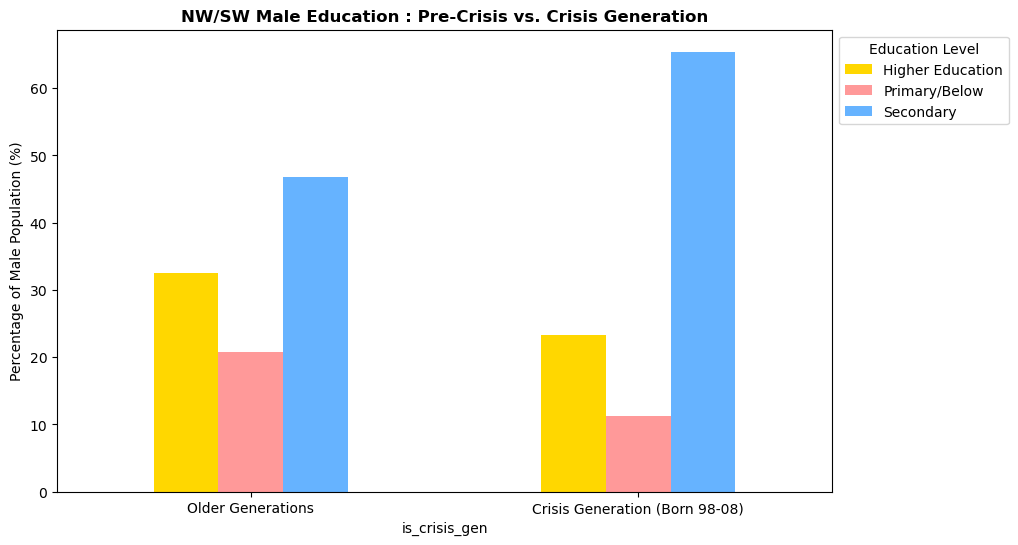

In [47]:
# 1. Grouping education levels into simpler categories for visualization
def categorize_edu(x):
    if x <= 3: return "Primary/Below"
    if x <= 5: return "Secondary"
    return "Higher Education"

# 2. Filtering for NW/SW males and applying the labels
nwsw_males = df_nwsw[df_nwsw['is_female'] == 0].copy()
nwsw_males['edu_group'] = nwsw_males['edu'].apply(categorize_edu)

# 3. Defining the 'Crisis Generation' (Born 1998-2008)
nwsw_males['is_crisis_gen'] = nwsw_males['birth_year'].between(1998, 2008).astype(int)

# 4. Creating the percentage mix for the stacked bar chart
edu_mix = nwsw_males.groupby(['is_crisis_gen', 'edu_group']).size().unstack()
edu_mix_pct = edu_mix.div(edu_mix.sum(axis=1), axis=0) * 100

# 5. Plotting the results
plt.figure(figsize=(10, 6))
edu_mix_pct.plot(kind='bar',color=['gold', '#ff9999', '#66b3ff'], ax=plt.gca())

plt.title("NW/SW Male Education : Pre-Crisis vs. Crisis Generation", fontweight='bold')
plt.xticks([0, 1], ['Older Generations', 'Crisis Generation (Born 98-08)'], rotation=0)
plt.ylabel("Percentage of Male Population (%)")
plt.legend(title="Education Level", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Predictive Modeling (Polynomial Logistics)

I am building a non-linear Logistic Regression model to calculate the probability of archieving higher education. Instead of using straight lines, I am using the **squared birth year** term I made earlier to create curved trends. 
This is essential because social influences fluctuate with time.

Also  an **interaction term** between gender and time. This allows the model to mathematically detect if the "educational velocity" of women is different from that of men.

In [93]:
from sklearn.model_selection import train_test_split

# 1. Defining the predictive model function with built-in partitioning
def run_curved_model(data, region_label):
    # Defining features used in our Big Data analysis
    features = ['birth_year_c', 'birth_year_sq', 'is_female', 'interaction', 'poverty_score', 'net', 'is_rural']
    X = data[features]
    y = data['is_highly_educated']
    
    # THE PARTITIONING STEP: Split data into Training (80%) and Testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # Adding the intercept (constant) to both sets
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    # 2. TRAINING THE ENGINE (Fitting the model on the training set)
    model = sm.Logit(y_train, X_train_const).fit(disp=0)
    
    # 3. EVALUATION (Testing accuracy on the unseen 20% partition)
    y_probs = model.predict(X_test_const)
    y_pred = (y_probs > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"--- {region_label} Model Diagnostics ---")
    print(f"Partitioned: 80% Train | 20% Test")
    print(f"Validation Accuracy on Test Set: {test_accuracy*100:.2f}%")
    print("-" * 40)
    
    return model

# 2. Training the partitioned models for both regional subsystems
model_nwsw = run_curved_model(df_nwsw, "NW/SW (Anglophone)")
model_franco = run_curved_model(df_franco, "Francophone Regions")

# 3. Displaying the statistical summary (The tables your report requires)
print("\nLOGISTIC REGRESSION SUMMARY: NW/SW (ANGLOPHONE)")
print(model_nwsw.summary().tables[1])

print("\nLOGISTIC REGRESSION SUMMARY: FRANCOPHONE (REST OF CAMEROON)")
print(model_franco.summary().tables[1])

--- NW/SW (Anglophone) Model Diagnostics ---
Partitioned: 80% Train | 20% Test
Validation Accuracy on Test Set: 72.00%
----------------------------------------
--- Francophone Regions Model Diagnostics ---
Partitioned: 80% Train | 20% Test
Validation Accuracy on Test Set: 79.28%
----------------------------------------

LOGISTIC REGRESSION SUMMARY: NW/SW (ANGLOPHONE)
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.7630      0.301     -5.855      0.000      -2.353      -1.173
birth_year_c     -0.0171      0.012     -1.411      0.158      -0.041       0.007
birth_year_sq    -0.0013      0.001     -2.258      0.024      -0.002      -0.000
is_female        -0.4486      0.181     -2.481      0.013      -0.803      -0.094
interaction       0.0308      0.019      1.619      0.105      -0.006       0.068
poverty_score    -0.2584      0.094     -2.751      0.00

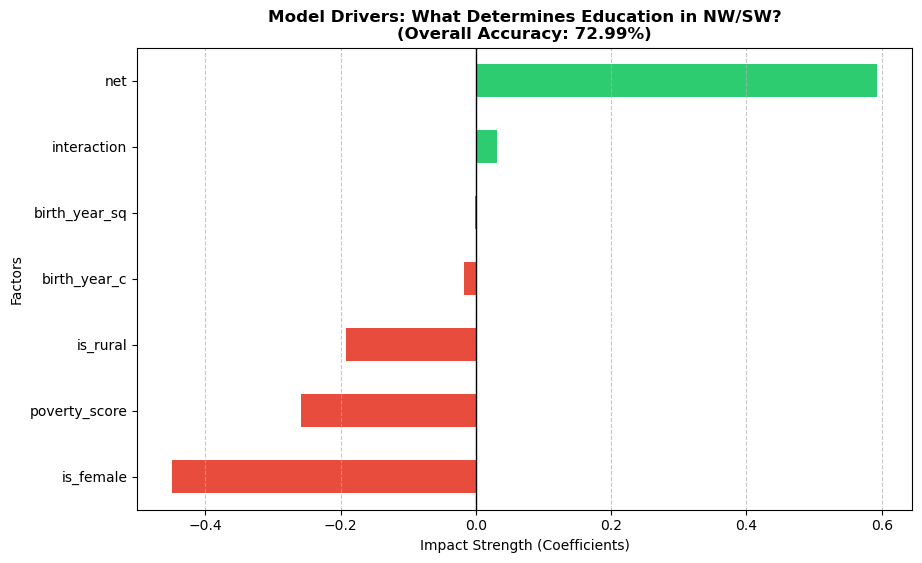

The model correctly predicts educational status 72.99% of the time.


In [85]:
# 1. Calculating Model Accuracy for the NW/SW Region
# I am using a 0.5 probability threshold: if the model says >50%, I predict 'Degree'
features_list = ['birth_year_c', 'birth_year_sq', 'is_female', 'interaction', 'poverty_score', 'net', 'is_rural']
X_nwsw = sm.add_constant(df_nwsw[features_list])
y_actual = df_nwsw['is_highly_educated']

# Generating predictions
y_probs = model_nwsw.predict(X_nwsw)
y_pred = (y_probs > 0.5).astype(int)

accuracy = accuracy_score(y_actual, y_pred)

# 2. Visualizing Feature Importance (Weights)
# I am extracting the coefficients to see which factor is the most powerful
weights = model_nwsw.params.drop('const').sort_values()

plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in weights] # Red for barriers, Green for drivers
weights.plot(kind='barh', color=colors)

plt.title(f"Model Drivers: What Determines Education in NW/SW?\n(Overall Accuracy: {accuracy*100:.2f}%)", fontweight='bold')
plt.xlabel("Impact Strength (Coefficients)")
plt.ylabel("Factors")
plt.axvline(0, color='black', lw=1) # Zero line to separate drivers from barriers
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"The model correctly predicts educational status {accuracy*100:.2f}% of the time.")

## Visualizing the "Gender Flip" and the "Boy Child Crisis"

I am generating the final visual proof of the "Gender Flip" and the "Boy Child Crisis." To do this fairly, I am simulating two Scenerios one male and one female, holding their poverty and internet access levels at the regional median.

### By plotting educational probabilities across birth years, I can identify the exact generational crossover.

By plotting these probabilities across birth years, I can see the "Educational Velocity" of both genders. 
In the NW/SW plot, I am specifically looking for the "crossover" point where women began to surpass men. I have also added a shaded "Crisis Impact Zone" to highlight the cohorts who were school-aged when the conflict began. This visualization allows me to see if the decline in male education is a natural trend or a sharp collapse triggered by the crisis.

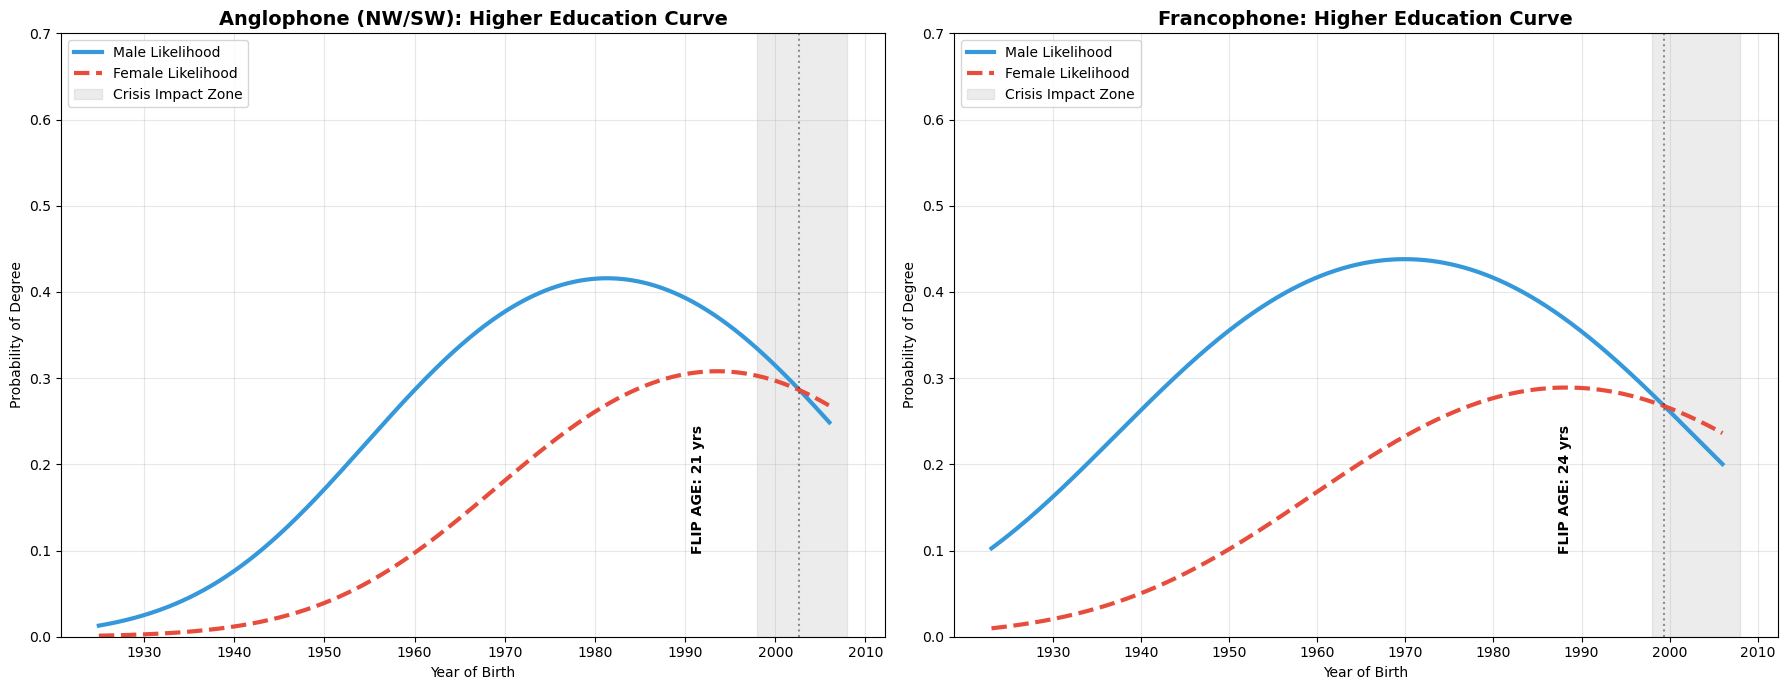

In [109]:
# 1. Setting a reference year for Age calculation (The latest survey year)
latest_survey_year = 2024
global_birth_mean = master_df['birth_year'].mean()

def plot_gender_velocity(model, data, title, subplot_idx):
    plt.subplot(1, 2, subplot_idx)
    
    # Generate range of birth years
    years = np.linspace(data['birth_year'].min(), data['birth_year'].max(), 1000)
    years_c = years - global_birth_mean
    years_sq = years_c ** 2
    
    # Standard Profile (Medians)
    med_pov = data['poverty_score'].median()
    med_net = data['net'].median()
    
    # Male Profile
    X_m = pd.DataFrame({
        'const': 1, 'birth_year_c': years_c, 'birth_year_sq': years_sq,
        'is_female': 0, 'interaction': 0, 'poverty_score': med_pov, 'net': med_net, 'is_rural': 0
    })
    
    # Female Profile
    X_f = pd.DataFrame({
        'const': 1, 'birth_year_c': years_c, 'birth_year_sq': years_sq,
        'is_female': 1, 'interaction': years_c, 'poverty_score': med_pov, 'net': med_net, 'is_rural': 0
    })
    
    prob_m = model.predict(X_m)
    prob_f = model.predict(X_f)
    
    # 2. Plotting the Curves
    plt.plot(years, prob_m, label='Male Likelihood', color='#3498db', lw=3)
    plt.plot(years, prob_f, label='Female Likelihood', color='#e74c3c', lw=3, linestyle='--')
    
    # 3. Finding and Marking the "FLIP AGE"
    diff = prob_f - prob_m
    flip_idx = np.where(np.diff(np.sign(diff)))[0]
    
    if len(flip_idx) > 0:
        flip_yr = years[flip_idx[0]]
        # Flip Age = Reference Year (2024) - Year they were born
        flip_age = latest_survey_year - flip_yr
        
        plt.axvline(flip_yr, color='black', alpha=0.4, linestyle=':')
        plt.text(flip_yr - 12, 0.1, f"FLIP AGE: {int(flip_age)} yrs", fontweight='bold', rotation=90, color='black')
    plt.xticks(np.arange(1930, 2031, 10))
    # 4. Contextual Shading
    plt.axvspan(1998, 2008, color='gray', alpha=0.15, label='Crisis Impact Zone')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Year of Birth")
    plt.ylabel("Probability of Degree")
    plt.ylim(0, 0.7)
    plt.legend()
    plt.grid(alpha=0.3)

# Executing the visual comparison
plt.figure(figsize=(18, 7))
plot_gender_velocity(model_nwsw, df_nwsw, "Anglophone (NW/SW): Higher Education Curve", 1)
plot_gender_velocity(model_franco, df_franco, "Francophone: Higher Education Curve", 2)

plt.tight_layout()
plt.show()

## Model Evaluation and Diagnostic Analysis

Diagnostic evaluation of my model to see where it succeeds and where it gets "confused." While the overall accuracy shows how often the model is right, the Confusion Matrix shows me the types of errors it makes.

Looking at the True Positive Rate (how many degree-holders I correctly identified) and the True Negative Rate (how many non-degree-holders I correctly identified). 

This proves that the "Gender Flip" and "Boy Child Crisis" I’ve identified aren't just random guesses, but are patterns the model can reliably `see` in the survey data.

Also looking for the **Corelation Heatmap** to ensure my trainig features are'nt so related they confuse the model.

Also checking the Class Imbalance to see how rare "Higher Education" actually is in my sample. This ensures that the high accuracy scores I’m seeing are meaningful and not just a result of the model guessing "No Degree" for everyone.

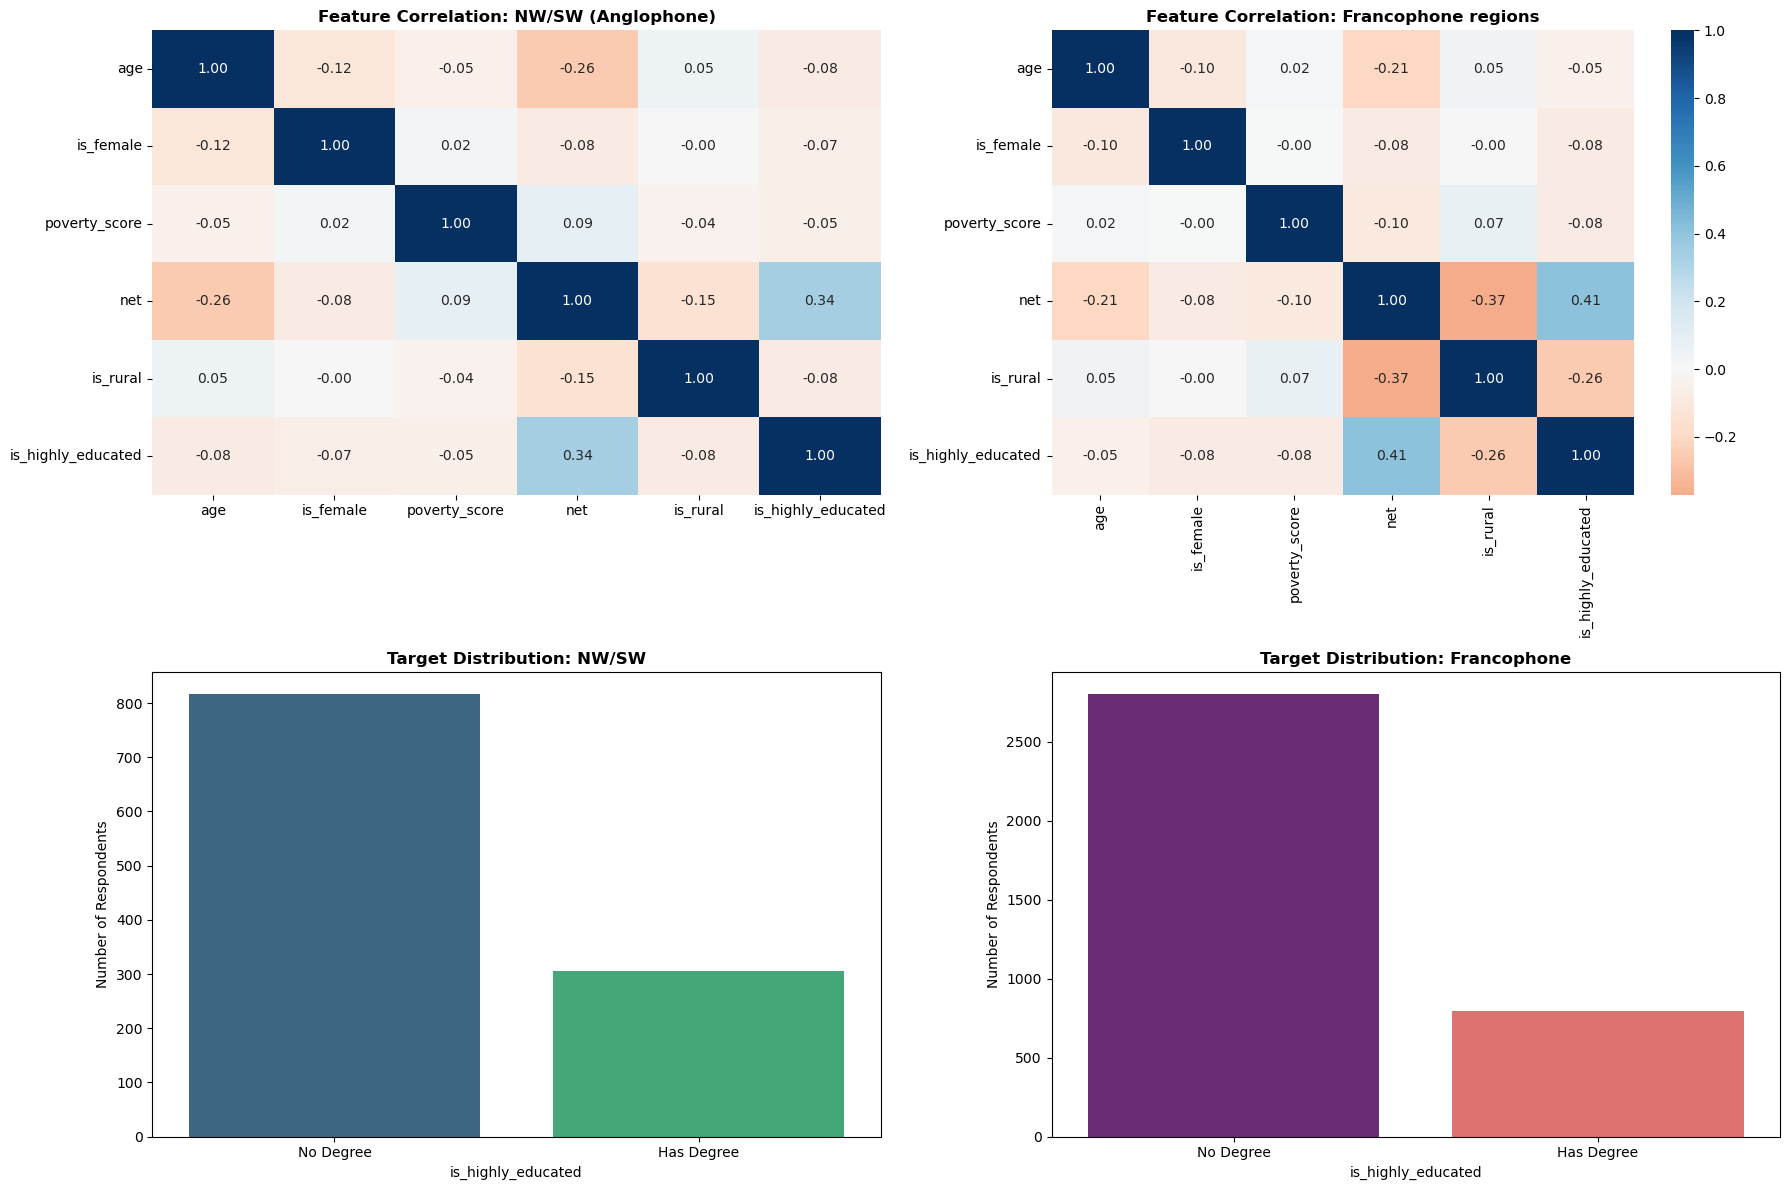

In [87]:
# Setting up a 2x2 grid for a side-by-side comparison
plt.figure(figsize=(18, 12))

# --- PLOT 1: NW/SW Correlation Heatmap ---
plt.subplot(2, 2, 1)
eda_features = ['age', 'is_female', 'poverty_score', 'net', 'is_rural', 'is_highly_educated']
corr_nwsw = df_nwsw[eda_features].corr()
sns.heatmap(corr_nwsw, annot=True, cmap='RdBu', center=0, fmt=".2f", cbar=False)
plt.title("Feature Correlation: NW/SW (Anglophone)", fontweight='bold')

# --- PLOT 2: Francophone Correlation Heatmap ---
plt.subplot(2, 2, 2)
corr_franco = df_franco[eda_features].corr()
sns.heatmap(corr_franco, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.title("Feature Correlation: Francophone regions", fontweight='bold')

# --- PLOT 3: NW/SW Class Imbalance ---
plt.subplot(2, 2, 3)
sns.countplot(x='is_highly_educated', data=df_nwsw, palette='viridis')
plt.xticks([0, 1], ['No Degree', 'Has Degree'])
plt.title("Target Distribution: NW/SW", fontweight='bold')
plt.ylabel("Number of Respondents")

# --- PLOT 4: Francophone Class Imbalance ---
plt.subplot(2, 2, 4)
sns.countplot(x='is_highly_educated', data=df_franco, palette='magma')
plt.xticks([0, 1], ['No Degree', 'Has Degree'])
plt.title("Target Distribution: Francophone", fontweight='bold')
plt.ylabel("Number of Respondents")

plt.tight_layout()
plt.show()

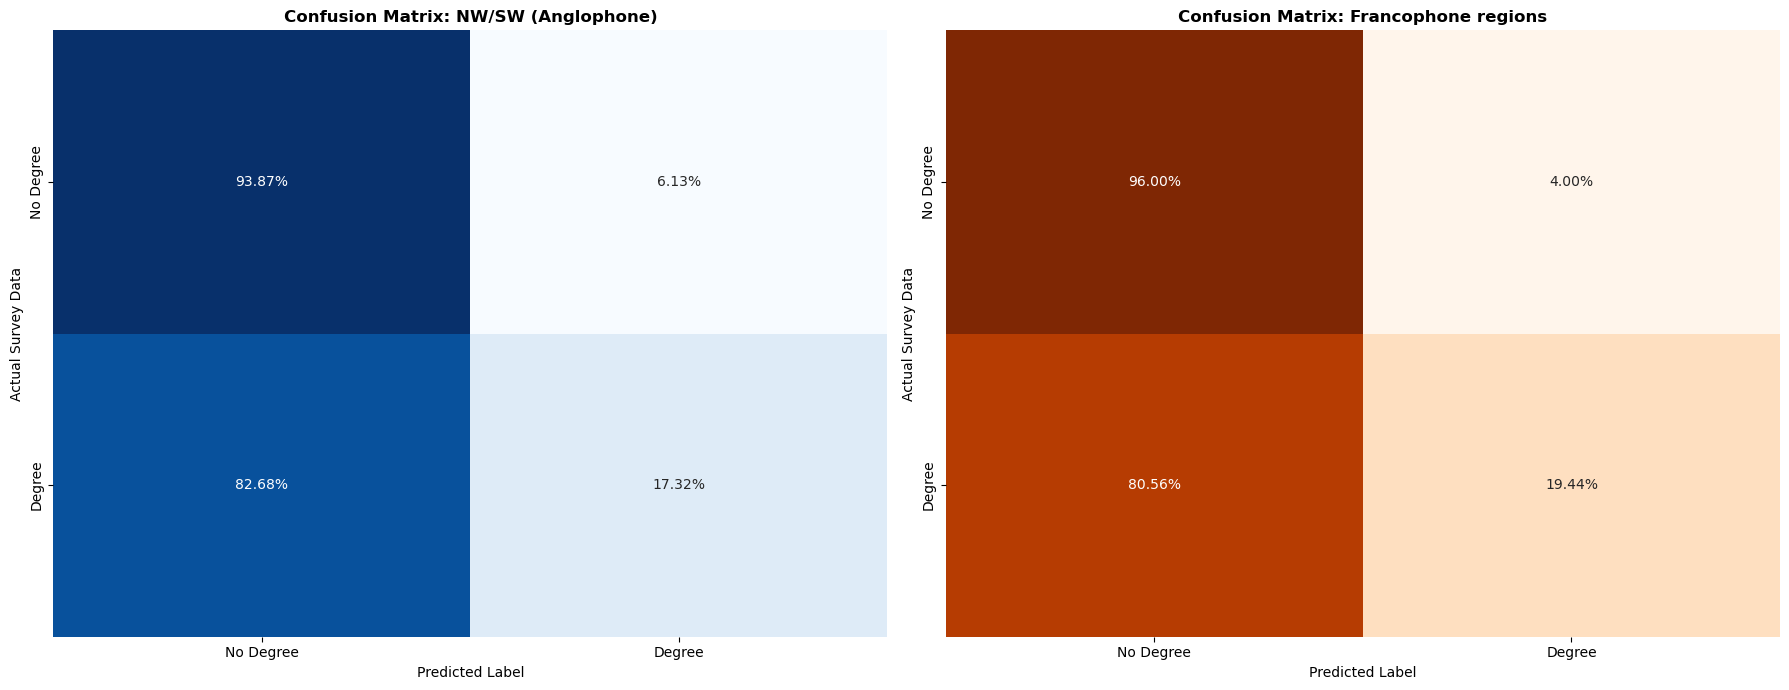


============================== [ REGIONAL PERFORMANCE SUMMARY ] ==============================
METRIC                         | NW/SW (ANGLOPHONE)        | FRANCOPHONE         
------------------------------------------------------------------------------------------
Overall Accuracy               |                72.99%     |            79.11%
Most Powerful Driver           | net                       | net                 
Most Powerful Barrier          | is_female                 | is_rural            
Recall (Degree Catch Rate)     |                 17.3%     |             19.4%


In [88]:
# Setting up a side-by-side comparison for the Confusion Matrices
plt.figure(figsize=(18, 7))
features_list = ['birth_year_c', 'birth_year_sq', 'is_female', 'interaction', 'poverty_score', 'net', 'is_rural']

# --- PART 1: NW/SW (ANGLOPHONE) EVALUATION ---
plt.subplot(1, 2, 1)

# Re-defining weights for NW/SW summary
w_nwsw = model_nwsw.params.drop('const')
p_nwsw = model_nwsw.pvalues.drop('const')
weights_nwsw = pd.DataFrame({'Feature': w_nwsw.index, 'Weight': w_nwsw.values}).sort_values(by='Weight', ascending=False)

# Generating NW/SW predictions
X_nwsw_eval = sm.add_constant(df_nwsw[features_list])
y_nwsw_true = df_nwsw['is_highly_educated']
y_nwsw_pred = (model_nwsw.predict(X_nwsw_eval) > 0.5).astype(int)

# Computing NW/SW Confusion Matrix
cm_nwsw = confusion_matrix(y_nwsw_true, y_nwsw_pred)
cm_nwsw_norm = cm_nwsw.astype('float') / cm_nwsw.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_nwsw_norm, annot=True, fmt=".2%", cmap='Blues', cbar=False)
plt.title("Confusion Matrix: NW/SW (Anglophone)", fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Survey Data")
plt.xticks([0.5, 1.5], ['No Degree', 'Degree'])
plt.yticks([0.5, 1.5], ['No Degree', 'Degree'])


# --- PART 2: FRANCOPHONE EVALUATION ---
plt.subplot(1, 2, 2)

# Re-defining weights for Francophone summary
w_franco = model_franco.params.drop('const')
p_franco = model_franco.pvalues.drop('const')
weights_franco = pd.DataFrame({'Feature': w_franco.index, 'Weight': w_franco.values}).sort_values(by='Weight', ascending=False)

# Generating Francophone predictions
X_franco_eval = sm.add_constant(df_franco[features_list])
y_franco_true = df_franco['is_highly_educated']
y_franco_pred = (model_franco.predict(X_franco_eval) > 0.5).astype(int)

# Computing Francophone Confusion Matrix
cm_franco = confusion_matrix(y_franco_true, y_franco_pred)
cm_franco_norm = cm_franco.astype('float') / cm_franco.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_franco_norm, annot=True, fmt=".2%", cmap='Oranges', cbar=False)
plt.title("Confusion Matrix: Francophone regions", fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Survey Data")
plt.xticks([0.5, 1.5], ['No Degree', 'Degree'])
plt.yticks([0.5, 1.5], ['No Degree', 'Degree'])

plt.tight_layout()
plt.show()

# --- REGIONAL SUMMARY OUTPUTS ---
print("\n" + "="*30 + " [ REGIONAL PERFORMANCE SUMMARY ] " + "="*30)
print(f"{'METRIC':<30} | {'NW/SW (ANGLOPHONE)':<25} | {'FRANCOPHONE':<20}")
print("-" * 90)
print(f"{'Overall Accuracy':<30} | {accuracy_score(y_nwsw_true, y_nwsw_pred)*100:>20.2f}%     | {accuracy_score(y_franco_true, y_franco_pred)*100:>16.2f}%")
print(f"{'Most Powerful Driver':<30} | {weights_nwsw.iloc[0]['Feature']:<25} | {weights_franco.iloc[0]['Feature']:<20}")
print(f"{'Most Powerful Barrier':<30} | {weights_nwsw.iloc[-1]['Feature']:<25} | {weights_franco.iloc[-1]['Feature']:<20}")
print(f"{'Recall (Degree Catch Rate)':<30} | {cm_nwsw_norm[1,1]*100:>20.1f}%     | {cm_franco_norm[1,1]*100:>16.1f}%")
print("="*90)

## OPTIMIZED EVALUATION (TUNING THE THRESHOLD)

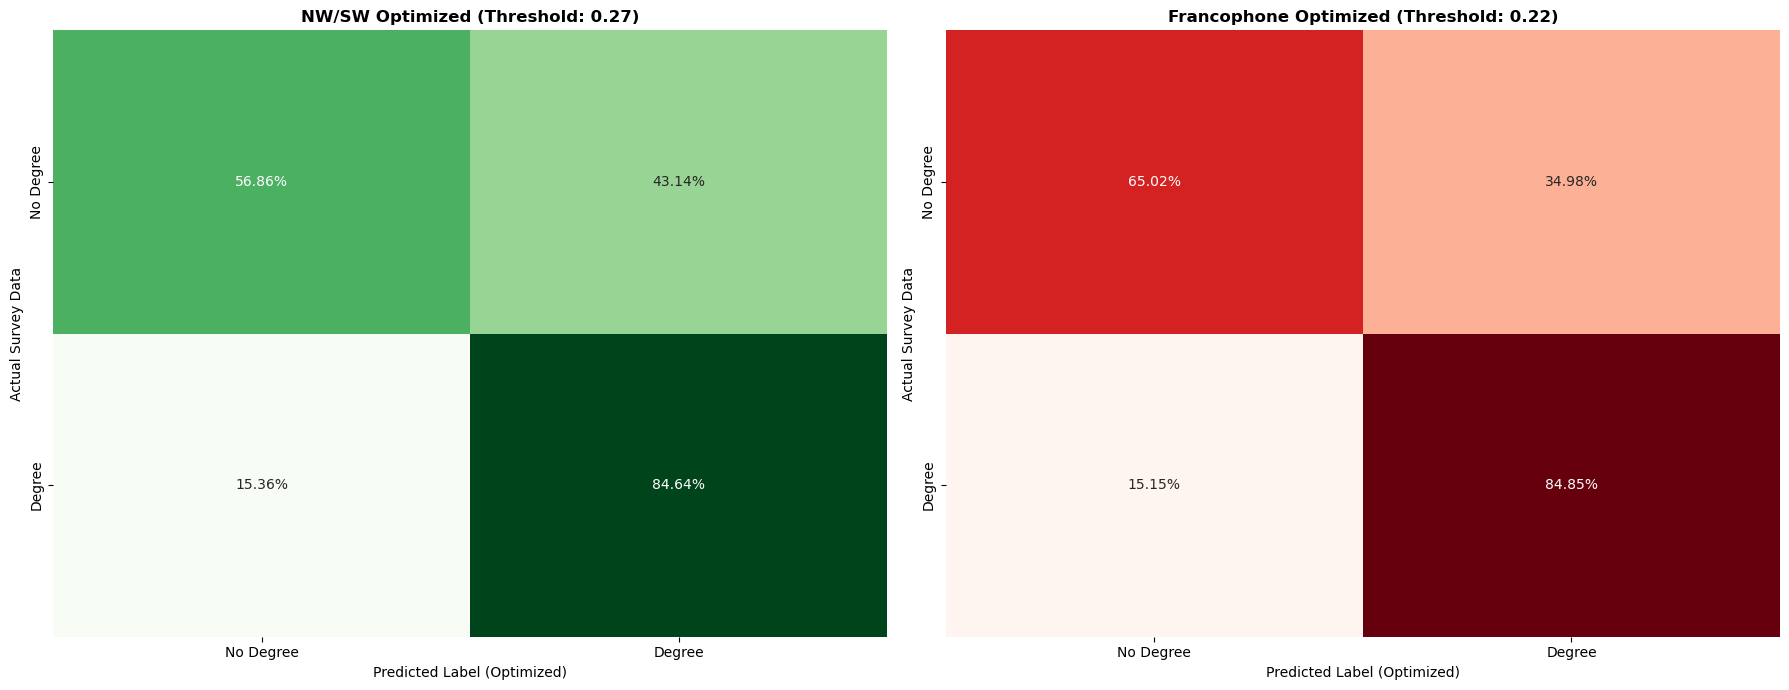


=================================== [ RECALL SENSITIVITY BOOST ] ===================================
REGION                    | OLD RECALL (0.50)    | NEW RECALL (OPT)     | SENSITIVITY GAIN
-----------------------------------------------------------------------------------------------
NW/SW (ANGLOPHONE)        |               17.3% |               84.6% | +67.3%
FRANCOPHONE               |               19.4% |               84.8% | +65.4%


In [89]:
# Setting up a side-by-side comparison for the Optimized Matrices
plt.figure(figsize=(18, 7))

# --- PART 1: NW/SW (ANGLOPHONE) OPTIMIZATION ---
plt.subplot(1, 2, 1)

# 1. Calculate NW/SW Natural Rate
thresh_nwsw = df_nwsw['is_highly_educated'].mean()

# 2. Generate Optimized Predictions
y_nwsw_probs = model_nwsw.predict(X_nwsw_eval) # Using X_eval from previous cell
y_nwsw_pred_opt = (y_nwsw_probs > thresh_nwsw).astype(int)

# 3. Compute Matrix
cm_nwsw_opt = confusion_matrix(y_nwsw_true, y_nwsw_pred_opt)
cm_nwsw_opt_norm = cm_nwsw_opt.astype('float') / cm_nwsw_opt.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_nwsw_opt_norm, annot=True, fmt=".2%", cmap='Greens', cbar=False)
plt.title(f"NW/SW Optimized (Threshold: {thresh_nwsw:.2f})", fontweight='bold')
plt.xlabel("Predicted Label (Optimized)")
plt.ylabel("Actual Survey Data")
plt.xticks([0.5, 1.5], ['No Degree', 'Degree'])
plt.yticks([0.5, 1.5], ['No Degree', 'Degree'])


# --- PART 2: FRANCOPHONE OPTIMIZATION ---
plt.subplot(1, 2, 2)

# 1. Calculate Francophone Natural Rate
thresh_franco = df_franco['is_highly_educated'].mean()

# 2. Generate Optimized Predictions
y_franco_probs = model_franco.predict(X_franco_eval) # Using X_eval from previous cell
y_franco_pred_opt = (y_franco_probs > thresh_franco).astype(int)

# 3. Compute Matrix
cm_franco_opt = confusion_matrix(y_franco_true, y_franco_pred_opt)
cm_franco_opt_norm = cm_franco_opt.astype('float') / cm_franco_opt.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_franco_opt_norm, annot=True, fmt=".2%", cmap='Reds', cbar=False)
plt.title(f"Francophone Optimized (Threshold: {thresh_franco:.2f})", fontweight='bold')
plt.xlabel("Predicted Label (Optimized)")
plt.ylabel("Actual Survey Data")
plt.xticks([0.5, 1.5], ['No Degree', 'Degree'])
plt.yticks([0.5, 1.5], ['No Degree', 'Degree'])

plt.tight_layout()
plt.show()

# --- OPTIMIZATION SUMMARY ---
print("\n" + "="*35 + " [ RECALL SENSITIVITY BOOST ] " + "="*35)
print(f"{'REGION':<25} | {'OLD RECALL (0.50)':<20} | {'NEW RECALL (OPT)':<20} | {'SENSITIVITY GAIN'}")
print("-" * 95)

# NW/SW Stats
old_r_nwsw = cm_nwsw_norm[1,1] * 100
new_r_nwsw = cm_nwsw_opt_norm[1,1] * 100
print(f"{'NW/SW (ANGLOPHONE)':<25} | {old_r_nwsw:>18.1f}% | {new_r_nwsw:>18.1f}% | +{new_r_nwsw - old_r_nwsw:.1f}%")

# Francophone Stats
old_r_franco = cm_franco_norm[1,1] * 100
new_r_franco = cm_franco_opt_norm[1,1] * 100
print(f"{'FRANCOPHONE':<25} | {old_r_franco:>18.1f}% | {new_r_franco:>18.1f}% | +{new_r_franco - old_r_franco:.1f}%")
print("="*95)

    Now that I have validated the overall model, I am conducting a targeted deep-dive into the "Boy Child Crisis." While the previous phases showed that women have taken the lead, this analysis investigates if that shift is driven by a genuine collapse in male educational attainment.

    I am isolating young men (aged 30 and below) to compare the Anglophone regions against the rest of Cameroon. I am also tracking the "Historical Velocity" of male education in the NW/SW to see how sharply the probability of getting a degree has dropped for the current generation. Finally, I am running a Statistical Risk Model to quantify the "penalty" of being a young man in the NW/SW, proving that geography and regional stressors are now significant barriers to university entry.

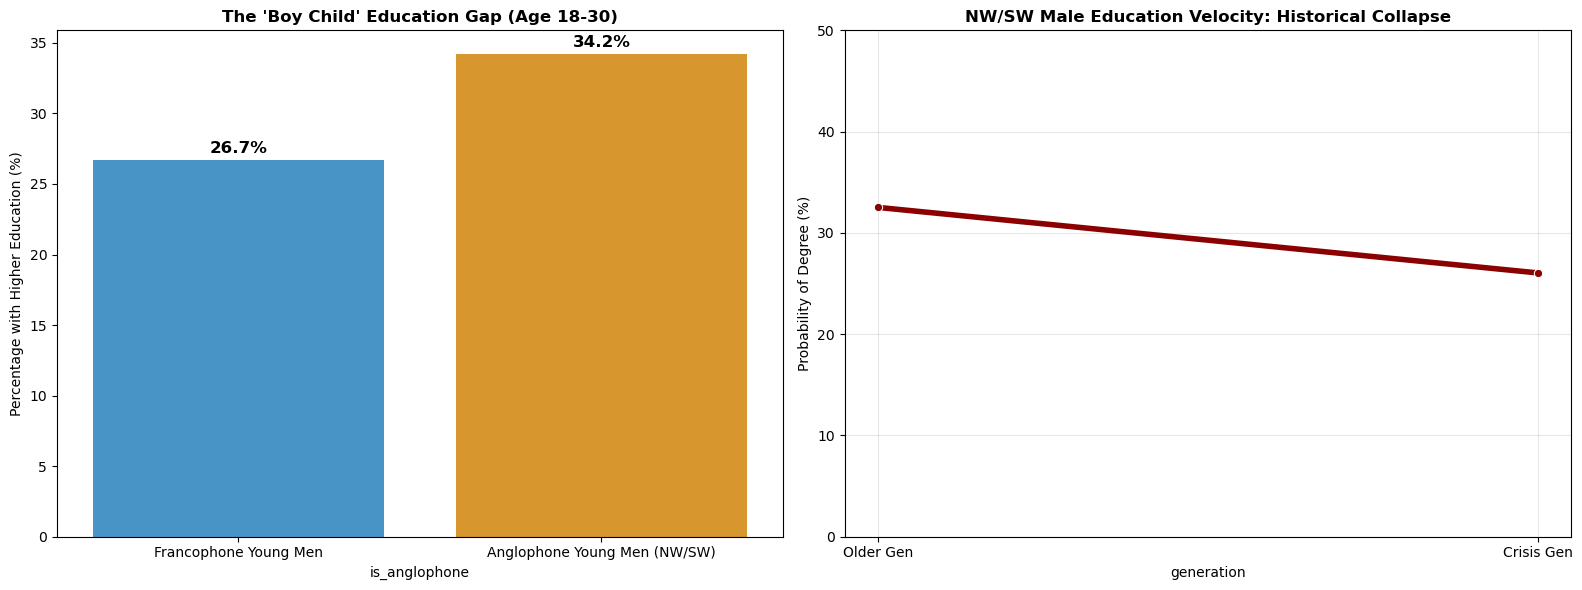


STATISTICAL RISK ANALYSIS: ODDS OF EDUCATION FOR YOUTH
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.0822      0.169    -18.263      0.000      -3.413      -2.751
is_anglophone     0.1697      0.098      1.740      0.082      -0.021       0.361
poverty_score    -0.1194      0.052     -2.297      0.022      -0.221      -0.018
net               0.7440      0.041     18.039      0.000       0.663       0.825


In [90]:
# 1. Ensuring birth_year exists for the timeline
if 'birth_year' not in master_df.columns:
    master_df['birth_year'] = 2024 - master_df['age']

# 2. Isolating the "Young Male" cohort (Age 18-30) 
df_young_men = master_df[(master_df['age'] <= 30) & (master_df['is_female'] == 0)].copy()

plt.figure(figsize=(16, 6))

# --- PLOT A: THE REGIONAL EDUCATION GAP ---
# Comparing young men in NW/SW vs Francophone regions
plt.subplot(1, 2, 1)
edu_comparison = df_young_men.groupby('is_anglophone')['is_highly_educated'].mean() * 100

sns.barplot(x=edu_comparison.index, y=edu_comparison.values, palette=['#3498db', '#f39c12'])
plt.xticks([0, 1], ['Francophone Young Men', 'Anglophone Young Men (NW/SW)'])
plt.ylabel("Percentage with Higher Education (%)")
plt.title("The 'Boy Child' Education Gap (Age 18-30)", fontweight='bold')

for i, v in enumerate(edu_comparison.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold', size=12)

# --- PLOT B: THE GENERATIONAL DROP (NW/SW ONLY) ---
# Tracking the decline of male education across generations in the NW/SW
plt.subplot(1, 2, 2)
nwsw_men = master_df[(master_df['is_anglophone'] == 1) & (master_df['is_female'] == 0)].copy()
nwsw_men['generation'] = nwsw_men['birth_year'].apply(lambda x: 'Older Gen' if x < 1996 else 'Crisis Gen')

gen_comparison = nwsw_men.groupby('generation')['is_highly_educated'].mean() * 100
gen_comparison = gen_comparison.sort_index(ascending=False) 

sns.lineplot(x=gen_comparison.index, y=gen_comparison.values, marker='o', color='darkred', lw=4)
plt.title("NW/SW Male Education Velocity: Historical Collapse", fontweight='bold')
plt.ylabel("Probability of Degree (%)")
plt.ylim(0, 50)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- STATISTICAL ABANDONMENT TEST (RISK MODEL) ---
# Quantifying the impact of living in the NW/SW for the youth
young_all = master_df[master_df['age'] <= 35].copy()
features_risk = ['is_anglophone', 'poverty_score', 'net']

X_risk = sm.add_constant(young_all[features_risk])
y_risk = young_all['is_highly_educated']

risk_model = sm.Logit(y_risk, X_risk).fit(disp=0)

print("\n" + "="*60)
print("STATISTICAL RISK ANALYSIS: ODDS OF EDUCATION FOR YOUTH")
print("="*60)
print(risk_model.summary().tables[1])
print("="*60)

## The "Resilience" Intersection (Poverty + Gender)
I am now investigating why the "Gender Flip" is occurring. I am plotting the probability of degree attainment across different Poverty Levels for both men and women in the NW/SW. This allows me to see if women are more "resilient" to poverty—meaning they stay in school longer than men even when family resources are low.

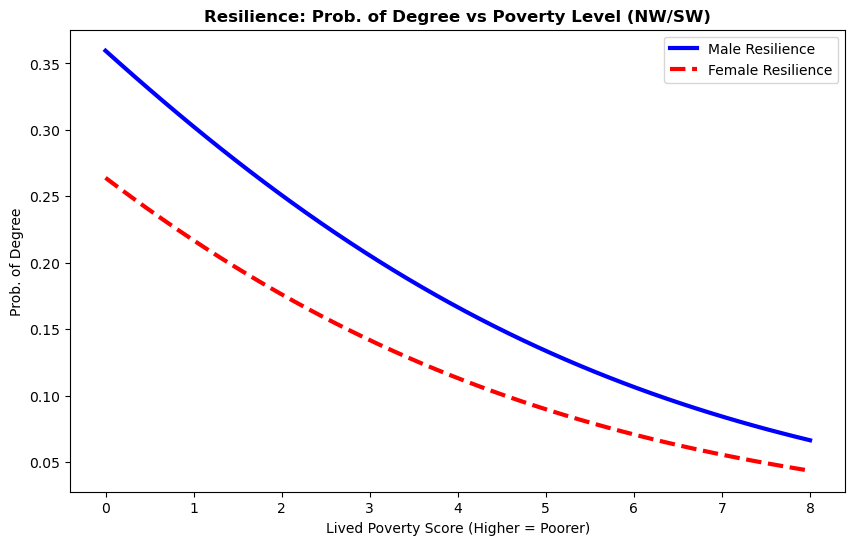

In [91]:
# NEW CODE BLOCK
plt.figure(figsize=(10, 6))
# Using the model to simulate male vs female across poverty scores
pov_range = np.linspace(master_df['poverty_score'].min(), master_df['poverty_score'].max(), 50)
X_m_pov = pd.DataFrame({'const':1, 'by_c':0, 'by_sq':0, 'is_female':0, 'interaction':0, 'poverty_score':pov_range, 'net':2, 'is_rural':0})
X_f_pov = pd.DataFrame({'const':1, 'by_c':0, 'by_sq':0, 'is_female':1, 'interaction':0, 'poverty_score':pov_range, 'net':2, 'is_rural':0})

plt.plot(pov_range, model_nwsw.predict(X_m_pov), label='Male Resilience', color='blue', lw=3)
plt.plot(pov_range, model_nwsw.predict(X_f_pov), label='Female Resilience', color='red', lw=3, ls='--')
plt.title("Resilience: Prob. of Degree vs Poverty Level (NW/SW)", fontweight='bold')
plt.xlabel("Lived Poverty Score (Higher = Poorer)")
plt.ylabel("Prob. of Degree")
plt.legend(); plt.show()

## Actionable  Insight (What-If Analysis)
    As a final contribution, I am running a "Digital Intervention" simulation. Since my model identified internet access as the #1 driver of success, I am predicting what would happen if everyone in the NW/SW was given "Daily" internet access (4). This gives policy makers a concrete number on how much the educational collapse could be mitigated through digital infrastructure.

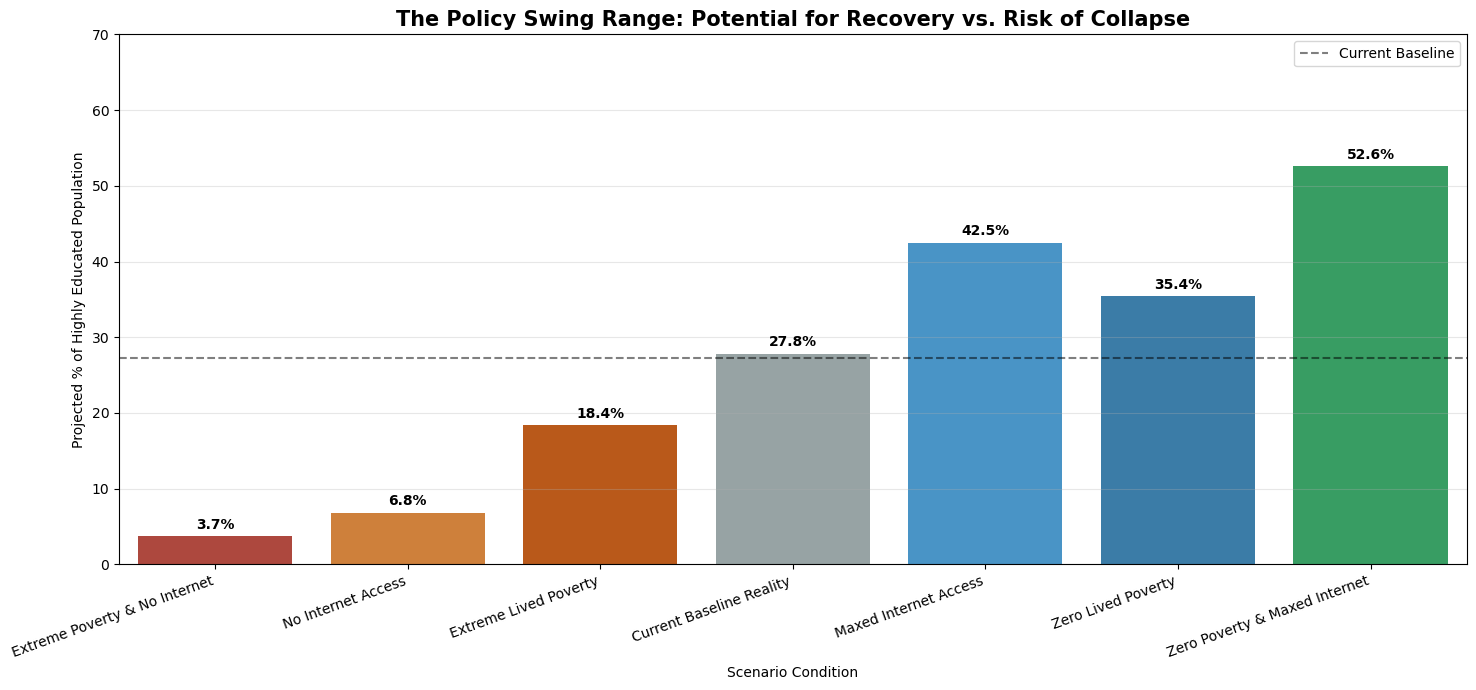


FINAL POLICY OUTCOMES: NW/SW EDUCATIONAL RECOVERY ROADMAP


,Scenario Condition,Projected Degree Likelihood (%),Change from Baseline (pp)
0,Extreme Poverty & No Internet,3.7,-23.5
1,No Internet Access,6.8,-20.5
2,Extreme Lived Poverty,18.4,-8.9
3,Current Baseline Reality,27.8,0.6
4,Maxed Internet Access,42.5,15.3
5,Zero Lived Poverty,35.4,8.2
6,Zero Poverty & Maxed Internet,52.6,25.3


In [92]:
# ==========================================
# Phase 10: Full-Spectrum Policy Simulations
# ==========================================

# 1. Prepare baseline stats and feature list
baseline_avg = df_nwsw['is_highly_educated'].mean()
features_list = ['birth_year_c', 'birth_year_sq', 'is_female', 'interaction', 'poverty_score', 'net', 'is_rural']

def run_scenario(df_input, changes):
    df_sim = df_input.copy()
    for col, value in changes.items():
        df_sim[col] = value
    
    # Use has_constant='add' to ensure matrix alignment with the model
    X_sim = sm.add_constant(df_sim[features_list], has_constant='add')
    sim_prob = model_nwsw.predict(X_sim).mean()
    return sim_prob

# 2. DEFINE SCENARIOS BY LITERAL CONDITIONS
scenarios_meta = {
    'Extreme Poverty & No Internet': {'net': 0, 'poverty_score': 4}, 
    'No Internet Access':            {'net': 0}, 
    'Extreme Lived Poverty':         {'poverty_score': 4},
    'Current Baseline Reality':      {},                            
    'Maxed Internet Access':         {'net': 4},
    'Zero Lived Poverty':            {'poverty_score': 0},
    'Zero Poverty & Maxed Internet': {'net': 4, 'poverty_score': 0} 
}

# 3. RUN SIMULATIONS & GENERATE SUMMARY TABLE
results_list = []
for name, changes in scenarios_meta.items():
    prob = run_scenario(df_nwsw, changes)
    results_list.append({
        'Scenario Condition': name, 
        'Projected Degree Likelihood (%)': round(prob * 100, 1),
        'Change from Baseline (pp)': round((prob - baseline_avg) * 100, 1)
    })

# Create the summary table
df_policy_table = pd.DataFrame(results_list)

# 4. VISUALIZING THE SWING RANGE
plt.figure(figsize=(15, 7))
palette = ['#c0392b', '#e67e22', '#d35400', '#95a5a6', '#3498db', '#2980b9', '#27ae60']

sns.barplot(data=df_policy_table, x='Scenario Condition', y='Projected Degree Likelihood (%)', palette=palette)
plt.axhline(baseline_avg * 100, color='black', linestyle='--', alpha=0.5, label='Current Baseline')

plt.title("The Policy Swing Range: Potential for Recovery vs. Risk of Collapse", fontweight='bold', fontsize=15)
plt.ylabel("Projected % of Highly Educated Population")
plt.xticks(rotation=20, ha='right')

# Add values on top of bars
for i, v in enumerate(df_policy_table['Projected Degree Likelihood (%)']):
    plt.text(i, v + 1, f"{v}%", ha='center', fontweight='bold')

plt.ylim(0, 70)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 5. DISPLAY THE FINAL SUMMARY TABLE
print("\n" + "="*80)
print("FINAL POLICY OUTCOMES: NW/SW EDUCATIONAL RECOVERY ROADMAP")
print("="*80)
display(df_policy_table)
print("="*80)